## Libraries


In [ ]:
# make session persistent
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import librosa
import librosa.display
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")
import IPython.display as ipd
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.io import wavfile
import shutil



## Read Dataset and upload it here

In [ ]:
!git clone "https://github.com/virufy/virufy-cdf-coughvid.git"
%cd virufy-cdf-coughvid

Cloning into 'virufy-cdf-coughvid'...
remote: Enumerating objects: 22051, done.
remote: Total 22051 (delta 0), reused 0 (delta 0), pack-reused 22051
Receiving objects: 100% (22051/22051), 1006.41 MiB | 31.70 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Checking out files: 100% (22045/22045), done.
/content/virufy-cdf-coughvid


In [ ]:
coughvid = pd.read_csv("virufy-cdf-coughvid.csv")
coughvid.head()
x, sr = librosa.load('virufy-cdf-coughvid/0009eb28-d8be-4dc1-92bb-907e53bc5c7a.webm')
#ipd.Audio('virufy-cdf-coughvid/0009eb28-d8be-4dc1-92bb-907e53bc5c7a.webm') 


In [ ]:
coughvid.head()

,Unnamed: 0,source,patient_id,cough_detected,cough_path,age,biological_sex,reported_gender,submission_date,pcr_test_date,pcr_result_date,respiratory_condition,fever_or_muscle_pain,pcr_test_result,pcr_test_result_inferred,covid_symptoms
0,0,coughvid,ae029647-ddc3-47f5-904e-813358c9dda3,0.8929,virufy-cdf-coughvid/ae029647-ddc3-47f5-904e-81...,NaN,NaN,NaN,2020-10-20T11:05:04.501905+00:00,NaN,NaN,NaN,NaN,untested,untested,NaN
1,1,coughvid,cac4a470-bb86-4db9-9453-d4e2706c3931,0.1431,virufy-cdf-coughvid/cac4a470-bb86-4db9-9453-d4...,NaN,NaN,NaN,2020-04-17T15:12:14.379396+00:00,NaN,NaN,NaN,NaN,untested,untested,NaN
2,2,coughvid,2a3d201f-7c70-449c-adc5-50de728fccd0,0.0803,virufy-cdf-coughvid/2a3d201f-7c70-449c-adc5-50...,38.0,male,male,2020-04-09T20:56:01.725275+00:00,NaN,NaN,False,False,untested,negative,False
3,3,coughvid,8b267d78-97f0-4530-bbfa-e938724376f4,0.1247,virufy-cdf-coughvid/8b267d78-97f0-4530-bbfa-e9...,NaN,NaN,NaN,2020-04-11T11:12:19.213465+00:00,NaN,NaN,NaN,NaN,untested,untested,NaN
4,4,coughvid,68d5215b-afdb-4b7a-81d3-fbd5677de7b4,1.0000,virufy-cdf-coughvid/68d5215b-afdb-4b7a-81d3-fb...,46.0,male,male,2020-11-26T16:21:47.764016+00:00,NaN,NaN,False,False,untested,negative,False


In [ ]:
index = coughvid.index
number_of_rows = len(index)
print(number_of_rows)

22040


In [ ]:
coughvid[['patient_id', 'pcr_test_result']]


,patient_id,pcr_test_result
0,ae029647-ddc3-47f5-904e-813358c9dda3,untested
4,68d5215b-afdb-4b7a-81d3-fbd5677de7b4,untested
5,3449851d-799e-404e-b143-58e852332948,untested
6,0c35e382-31cd-42cb-bc87-8a84b9c52a41,positive
9,3ee8bfb5-a1d4-46c6-9b1c-3052af9bdedf,untested
...,...,...
22029,ccc3b8b2-8c07-4aaa-adad-f8304402ecc1,untested
22033,8fc4db57-635e-4f38-ade1-b540c4587109,untested
22034,864e1796-6fcb-4b60-b79b-b103c5a49729,untested
22036,76682a59-1c14-44e8-93b9-f9f5f774e897,untested


#Visualizing Audio

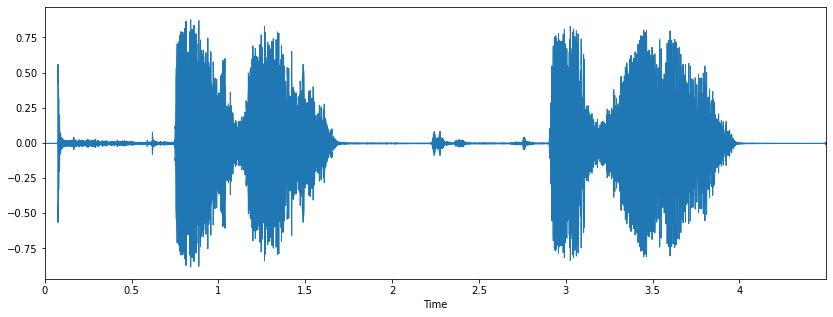

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

In [ ]:
coughvid = pd.read_csv("virufy-cdf-coughvid.csv")
msk = (coughvid.loc[:,'cough_detected'] > 0.7) #mask for filter cough detected which smaller than 0.7
coughvid = coughvid.loc[msk,:] #apply mask to each row

In [ ]:
coughvid.head()


,Unnamed: 0,source,patient_id,cough_detected,cough_path,age,biological_sex,reported_gender,submission_date,pcr_test_date,pcr_result_date,respiratory_condition,fever_or_muscle_pain,pcr_test_result,pcr_test_result_inferred,covid_symptoms
0,0,coughvid,ae029647-ddc3-47f5-904e-813358c9dda3,0.8929,virufy-cdf-coughvid/ae029647-ddc3-47f5-904e-81...,NaN,NaN,NaN,2020-10-20T11:05:04.501905+00:00,NaN,NaN,NaN,NaN,untested,untested,NaN
4,4,coughvid,68d5215b-afdb-4b7a-81d3-fbd5677de7b4,1.0000,virufy-cdf-coughvid/68d5215b-afdb-4b7a-81d3-fb...,46.0,male,male,2020-11-26T16:21:47.764016+00:00,NaN,NaN,False,False,untested,negative,False
5,5,coughvid,3449851d-799e-404e-b143-58e852332948,0.9825,virufy-cdf-coughvid/3449851d-799e-404e-b143-58...,47.0,male,male,2020-04-14T19:39:05.755132+00:00,NaN,NaN,False,False,untested,negative,False
6,6,coughvid,0c35e382-31cd-42cb-bc87-8a84b9c52a41,1.0000,virufy-cdf-coughvid/0c35e382-31cd-42cb-bc87-8a...,27.0,female,female,2020-04-13T09:11:44.729740+00:00,NaN,NaN,False,False,positive,positive,NaN
9,9,coughvid,3ee8bfb5-a1d4-46c6-9b1c-3052af9bdedf,0.9943,virufy-cdf-coughvid/3ee8bfb5-a1d4-46c6-9b1c-30...,NaN,NaN,NaN,2020-04-12T20:09:17.098213+00:00,NaN,NaN,NaN,NaN,untested,untested,NaN


In [ ]:
coughvid['pcr_test_result_inferred'].value_counts()#counts of unique values

negative    7178
untested    5399
positive     588
Name: pcr_test_result_inferred, dtype: int64

In [ ]:
msk = (coughvid.loc[:,'pcr_test_result_inferred']=='untested')#filter out untested results
coughvid = coughvid.loc[~msk,:]
coughvid['pcr_test_result_inferred'].value_counts()

negative    7178
positive     588
Name: pcr_test_result_inferred, dtype: int64

## Preprocessing  Stage


# 1- sampling data and determine freq


In [ ]:
stratify_labels = coughvid["pcr_test_result_inferred"].map(lambda x: x if x is "positive" else "untested")
cdf_train, cdf_test = train_test_split(coughvid, test_size=0.2, random_state = 0, stratify = stratify_labels)

# 2- Audio preprocessing

In [ ]:
# Functions to process audio files into images and json features
def trim_silence(x, *args):
    try:
      """
      hop length: The number of samples between analysis frames
      frame_lengthint > 0 : The number of samples per analysis frame
      top_db number > 0 :The threshold (in decibels) below reference to consider as silence
      """
      pad,db_max,frame_length,hop_length = args[0],args[1],args[2],args[3]
    except: 
        print('Please enter the following arguments: pad,db_max,frame_length,hop_length')
        return

        """ function : Trim leading and trailing silence from an audio signal
        return : trimmed signal and  ints refer to intervals 
        """
    _, ints = librosa.effects.trim(x, top_db=db_max, frame_length=256, hop_length=64) 
    start = int(max(ints[0]-pad, 0))
    end   = int(min(ints[1]+pad, len(x)))
    return x[start:end]

def process_cough_file(path,trim,*args):
    try: 
      sr,removeaudio,chunk,db_max = args[0],args[1],args[2],args[3]
    except: 
        sr,removeaudio,chunk,db_max= 48000,False,3,50
    try:
        x,sr = librosa.load(path, sr=sr)      #return audio time series  
    except: 
        return -1
    
    if len(x)/sr < 0.3 or len(x)/sr > 30:
        return None,None  
    hop_length = np.floor(0.010*sr).astype(int) #10ms
    win_length = np.floor(0.020*sr).astype(int) #20ms  

    if removeaudio:
        os.remove(path)
    
    x = trim(x, 0.25*sr, db_max,win_length,hop_length) ##pass trim function
    x = x[:np.floor(chunk*sr).astype(int)]
    
    #pads to chunk size if smaller ### ------------------------------------------------------
    x_pad = np.zeros(int(sr*chunk))
    x_pad[:min(len(x_pad), len(x))] = x[:min(len(x_pad), len(x))]

    return [x_pad,sr,hop_length,win_length]

def get_melspec(sdir,audio,sr,name):
    #Mel Spectogram
    plt.ioff()
    fig = plt.figure()
    melspec  = librosa.feature.melspectrogram(y=audio,sr=sr) #compute melspectorgram
    s_db     = librosa.power_to_db(melspec, ref=np.max)#convert it to dicible
    librosa.display.specshow(s_db)
    fig.canvas.draw()
    img = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig=fig)
    #img = img[80:250,80:300]

    savepath = os.path.join(sdir,name+'.png') # Currently saving melspectrogram images to the folders specified in extract features
    cv2.imwrite(savepath,img)
    return savepath

def get_rawMFCCs(audio,sr,*args):
    try: 
      hop_length,win_length,n_mfcc,n_mels,n_ftt = args[0],args[1],args[2],args[3],args[4]
    except:
        hop_length = np.floor(0.010*sr).astype(int) #10ms
        win_length = np.floor(0.020*sr).astype(int) #20ms  
        n_mfcc,n_mels,n_ftt=13,13,2048

    rawMFCCs    = librosa.feature.mfcc(y=audio,sr=sr, n_mfcc=n_mfcc,n_mels=n_mels, n_fft=n_ftt, hop_length=hop_length)
    rawMFCCs    = np.mean(rawMFCCs.T,axis=0).tolist()
    return rawMFCCs

def getlabel(key, dataframe, chosen):
      return dataframe.loc[dataframe[chosen['id']]==key][chosen['pcr']].tolist()[0]

def extract(df, chosen, savedir):
    if not os.path.isdir(savedir):
        os.mkdir(savedir)
        
    keys, dirs = df[chosen['id']].tolist(),df[chosen['path']].tolist()  
    audio_objs = [process_cough_file(path,trim_silence) for path in dirs]
    false_indices = [i for i in range(len(audio_objs)) if isinstance(audio_objs[i],int) or isinstance(audio_objs[i],tuple)]

    audio_objs = [audio_objs[i] for i in range(len(audio_objs)) if i not in false_indices]
    audio_objs = np.array(audio_objs)
    audio,sr,hop_length,win_length = audio_objs[:,0],audio_objs[:,1],audio_objs[:,2],audio_objs[:,3]
    
    dirs = [dirs[i] for i in range(len(dirs)) if i not in false_indices]
    keys = [keys[i] for i in range(len(keys)) if i not in false_indices]
    data = {key:{'DIR':get_melspec(savedir,a_i,sr_i,key),
             'rawMFCC':get_rawMFCCs(a_i,sr_i),
             'label':getlabel(key, df, chosen)} for key,a_i,sr_i in list(zip(keys,audio,sr))}
    return data

def filter_DF(df):
    names = list(df.columns)
    chosen= {}
    for name in names:
        if 'inferred' in name.lower():
          chosen['pcr'] = name # Choosing the target (pcr_test_result_inferred)
        elif 'path' in name.lower():
          chosen['path'] = name
        elif 'patient' in name.lower() or 'id' == name.lower() :
          chosen['id'] = name
    return df[[chosen['id'],chosen['pcr'],chosen['path']]].dropna().reset_index(), chosen 

def extract_features(train_df, test_df):
    train_dataframe, train_chosen = filter_DF(train_df)
    test_dataframe, test_chosen = filter_DF(test_df)
    
    train_features = extract(train_dataframe, train_chosen, 'train_melspecs/')
    test_features = extract(test_dataframe, test_chosen, 'test_melspecs/')
    
    return train_features, test_features

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
train_features, test_features = extract_features(cdf_train, cdf_test)


In [ ]:

# Optional: Save json features
with open('train_features.json', 'w') as f:
    json.dump(train_features, f, indent=4)
with open('test_features.json', 'w') as f:
    json.dump(test_features, f, indent=4)

In [ ]:
shutil.move("/content/virufy-cdf-coughvid/train_melspecs", "/content/drive/MyDrive/Final_Machinfy")

'/content/drive/MyDrive/Final_Machinfy/train_melspecs'

In [ ]:
shutil.move("/content/virufy-cdf-coughvid/test_melspecs", "/content/drive/MyDrive/Final_Machinfy")

'/content/drive/MyDrive/Final_Machinfy/test_melspecs'

In [ ]:
for x in os.walk("/content/drive/MyDrive/Final_Mach"):
  print(len(x[2]))

0
6212
5746
466
1554
813
54


# Images modeling


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Make all other necessary imports.
%matplotlib inline

#to render higher resolution images
%config InlineBackend.figure_format = 'retina'
import numpy

from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import json
import os 

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
tfds.disable_progress_bar()

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Logger info
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
from keras.layers import Activation, Dense,Dropout,Conv2D, MaxPooling2D
from tensorflow.keras import layers
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import shutil


In [ ]:
import os
import random 
from glob import glob
from pathlib import Path
DATASET_DIR = "/content/drive/MyDrive/Final_Mach"
TRAIN_DIR = "/content/drive/MyDrive/Final_Mach/train_melspecs"
TEST_DIR = "/content/drive/MyDrive/Final_Mach/teest_melspecs"

In [ ]:
with open("/content/virufy-cdf-coughvid/train_features.json", "r") as read_file:
   data = json.load(read_file)
   print(len(data))
with open("/content/virufy-cdf-coughvid/test_features.json", "r") as read_file:
   data1 = json.load(read_file)
   print(len(data1))
data1.update(data) 

6212
1554


In [ ]:
all_data = [y for x in os.walk(DATASET_DIR) for y in glob(os.path.join(x[0], '*.png'))]
print(len(all_data))


14845


In [ ]:
c=0
for x in os.walk(DATASET_DIR):
  print(x)
  #print(len(x[2]))


('/content/drive/MyDrive/Final_Mach', ['train_melspecs', 'teest_melspecs', '.ipynb_checkpoints'], [])
('/content/drive/MyDrive/Final_Mach/train_melspecs', ['neg', '.ipynb_checkpoints', 'pos'], ['0db78979-06e5-4265-ba10-74f2bd05cc6f.png', 'e814db32-bf81-4ca6-8997-41f8c8ef34db.png', '09a1eae2-80e8-4526-85a7-e9be6cde70b4.png', '6387cfd3-64dd-4630-b9ed-9c5bfcdda823.png', '24f7177c-c147-4ea8-9a9e-6f273d4f6fe4.png', '87886c9e-5213-47b7-9dc9-9f9fc254a462.png', '9abb9ea7-6aec-490b-9c8f-daa4214fb3fa.png', 'caa4706b-4c0f-409b-b1eb-aa65208b6ae4.png', '17655713-9327-4b02-b836-b7a38be1642d.png', '22cb791b-2eba-480f-9eb3-69018bd25a04.png', 'b5377aef-24d7-4763-b781-1a5f368544f8.png', 'e607a9a2-e15a-48a9-aaec-506a91c4e918.png', '6922ada2-531e-47ac-841e-eb4fa86cf99d.png', '492a4d0c-7ed9-4585-8425-d1c151845e3e.png', '76ba0eb3-06fd-4cb9-a88d-39caa24039ab.png', 'fe02400d-61cc-4b46-a4df-11f93caaf9e4.png', 'c5a17f64-5195-463f-bd20-6c22efb88be9.png', 'f97fd469-4b75-488e-947a-184e2ee57876.png', '0f88ff35-3f66

In [ ]:
all_data="/content/drive/MyDrive/Final_Mach/train_melspecs/e814db32-bf81-4ca6-8997-41f8c8ef34db.png"

In [ ]:
all_data[49:]

'e814db32-bf81-4ca6-8997-41f8c8ef34db.png'

In [ ]:
all_labels = []
for i in range(6212):
  label=all_data[i][49:]
  label=label[:-4]
  if data1[label]["label"]=="negative":
    shutil.copy(all_data[i],"/content/drive/MyDrive/Final_Mach/train_melspecs/neg")
  else:
    shutil.copy(all_data[i],"/content/drive/MyDrive/Final_Mach/train_melspecs/pos")

  all_labels.append(data1[label]["label"])

In [ ]:
for i in range(1554):
  label=all_data[i][49:]
  label=label[:-4]
  if data1[label]["label"]=="negative":
    shutil.copy(all_data[i],"/content/drive/MyDrive/Final_Mach/teest_melspecs/neg")
  else:
    shutil.copy(all_data[i],"/content/drive/MyDrive/Final_Mach/teest_melspecs/pos")

  all_labels.append(data1[label]["label"])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Sample 25 images from dataset
indices = np.random.randint(0, len(all_data)/2, size=25)
images = [all_data[i] for i in indices]
labels = [all_labels[i] for i in indices]

# Plot the 25 images
plt.figure(figsize=(10,10))
for i in range(len(indices)):
    plt.subplot(5, 5, i + 1)
    image = mpimg.imread(images[i]) # Read image from disk
    plt.imshow(image)
    plt.title(labels[i])
    plt.axis('off')
    
plt.show()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64
HEIGHT = 224
WIDTH = 224
VAL_SPLIT = 0.1


# 1. Construct an instance of the `ImageDataGenerator` class
train_datagen =  ImageDataGenerator(
      rescale = 1.0/255,
      featurewise_std_normalization=True,
      samplewise_std_normalization=True,
      validation_split = VAL_SPLIT
    )

# 2. Retrieve the iterator
train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 5592 images belonging to 2 classes.


In [ ]:
val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    shuffle = True,
    seed = 7,
    color_mode='rgb',
    class_mode='categorical',
    subset='validation')

Found 620 images belonging to 2 classes.


In [ ]:
# Do the same steps for the test set

# 1. Construct an instance of the `ImageDataGenerator` class
test_datagen =  ImageDataGenerator(rescale = 1.0/255)

# 2. Retrieve the iterator
test_generator = test_datagen.flow_from_directory(TEST_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical')

Found 867 images belonging to 2 classes.


In [ ]:
images, labels = next(train_generator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


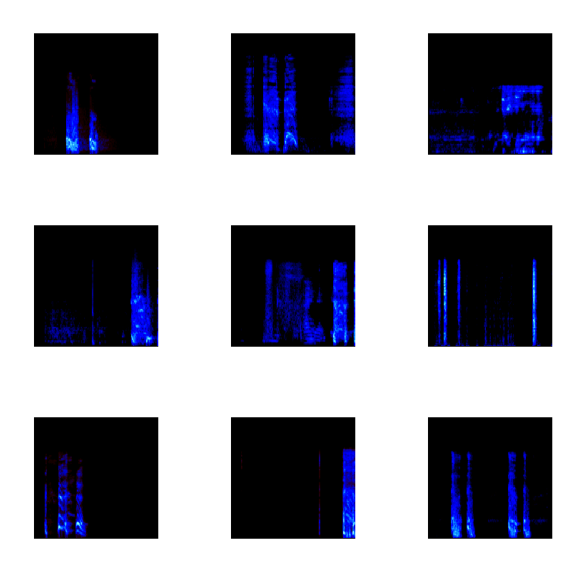

In [ ]:
plt.figure(figsize=(5, 5))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis("off")

In [ ]:
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential

def model_builder():
  # Specify model architecture
  model = Sequential()
  # Block 1
  model.add(Conv2D(32, (3, 3),
                  activation='relu',
                  kernel_initializer='he_uniform',
                  padding='same',
                  input_shape=(HEIGHT, WIDTH, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.25))
  # Block 2
  model.add(Conv2D(64,(3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
  # FC part
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(2, activation='softmax'))
  
  # Print summary
  model.summary()
  
  # Compile model
  model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])
  return model
 
model = model_builder()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 55, 55, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 193600)            0

In [ ]:
import tensorflow as tf

NUM_EPOCHS = 20

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(train_generator,
                    validation_data = val_generator,
                    callbacks = [earlystop],
                    epochs = NUM_EPOCHS)

Epoch 1/20
33/88 [==========>...................] - ETA: 11:05 - loss: 9.1878 - accuracy: 0.8982

In [ ]:
loss, acc = model.evaluate(test_generator)
print("Test accuracy is {}%".format(100*acc))

25/25 [==============================] - 8s 315ms/step - loss: 0.2480 - accuracy: 0.9350
Test accuracy is 93.50064396858215%


In [ ]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape=(224, 224,3))

feature_extractor.trainable = False

model = tf.keras.Sequential(feature_extractor)

model.add(Dense(2, kernel_regularizer='l1_l2',activation = 'softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(optimizer = "adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)
history = model.fit(train_generator,
                    epochs = 20,
                    validation_data=val_generator,
                    callbacks=[early_stopping])

Epoch 1/20
41/41 [==============================] - 54s 1s/step - loss: 1.0024 - accuracy: 0.9089 - val_loss: 0.7125 - val_accuracy: 0.9323
Epoch 2/20
41/41 [==============================] - 50s 1s/step - loss: 0.5624 - accuracy: 0.9324 - val_loss: 0.4577 - val_accuracy: 0.9323
Epoch 3/20
41/41 [==============================] - 50s 1s/step - loss: 0.3965 - accuracy: 0.9324 - val_loss: 0.3574 - val_accuracy: 0.9323
Epoch 4/20
41/41 [==============================] - 51s 1s/step - loss: 0.3314 - accuracy: 0.9324 - val_loss: 0.3131 - val_accuracy: 0.9323
Epoch 5/20
41/41 [==============================] - 51s 1s/step - loss: 0.3042 - accuracy: 0.9324 - val_loss: 0.2957 - val_accuracy: 0.9323


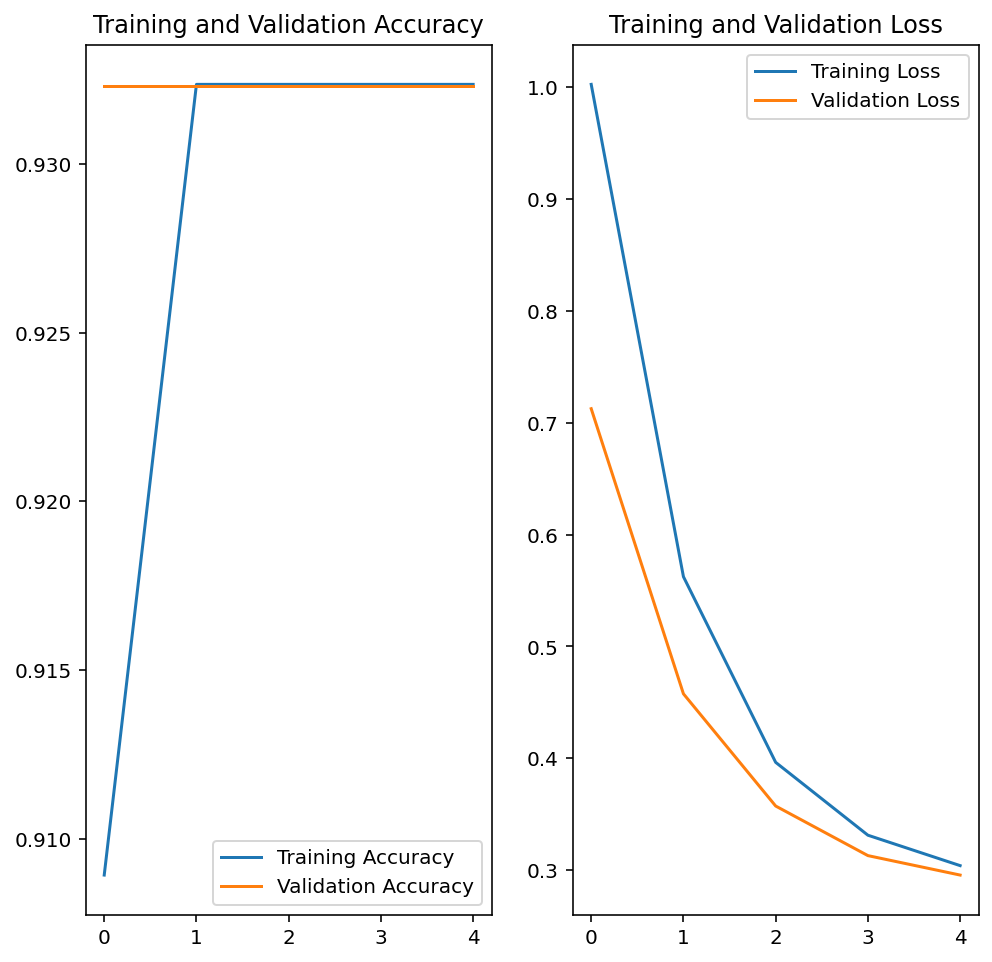

In [ ]:
# Plot the loss and accuracy values achieved during training for the training and validation set.
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

*Resnet 50 Arch**


In [ ]:
URL="https://tfhub.dev/google/bit/m-r50x1/ilsvrc2012_classification/1"

resnet_50 = hub.KerasLayer(URL, input_shape=(224, 224,3))
resnet_50.trainable = False

In [ ]:
model_3 = tf.keras.Sequential(resnet_50)
model_3.add(Dense(2, kernel_regularizer='l1_l2',activation = 'sigmoid'))

In [ ]:
model_3.compile(optimizer = "adamax",
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision()])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)
history = model_3.fit(train_generator,
                    epochs = 20,
                    validation_data=val_generator,
                    callbacks=[early_stopping])

Epoch 1/20
41/41 [==============================] - 62s 1s/step - loss: 1.2021 - precision_1: 0.8486 - val_loss: 1.0095 - val_precision_1: 0.9323
Epoch 2/20
41/41 [==============================] - 45s 1s/step - loss: 0.9440 - precision_1: 0.9320 - val_loss: 0.8845 - val_precision_1: 0.9323
Epoch 3/20
41/41 [==============================] - 45s 1s/step - loss: 0.8544 - precision_1: 0.9320 - val_loss: 0.8126 - val_precision_1: 0.9323
Epoch 4/20
41/41 [==============================] - 45s 1s/step - loss: 0.7882 - precision_1: 0.9324 - val_loss: 0.7548 - val_precision_1: 0.9323
Epoch 5/20
41/41 [==============================] - 45s 1s/step - loss: 0.7328 - precision_1: 0.9324 - val_loss: 0.7059 - val_precision_1: 0.9323
Epoch 6/20
41/41 [==============================] - ETA: 0s - loss: 0.6877 - precision_1: 0.9324

KeyboardInterrupt: ignored

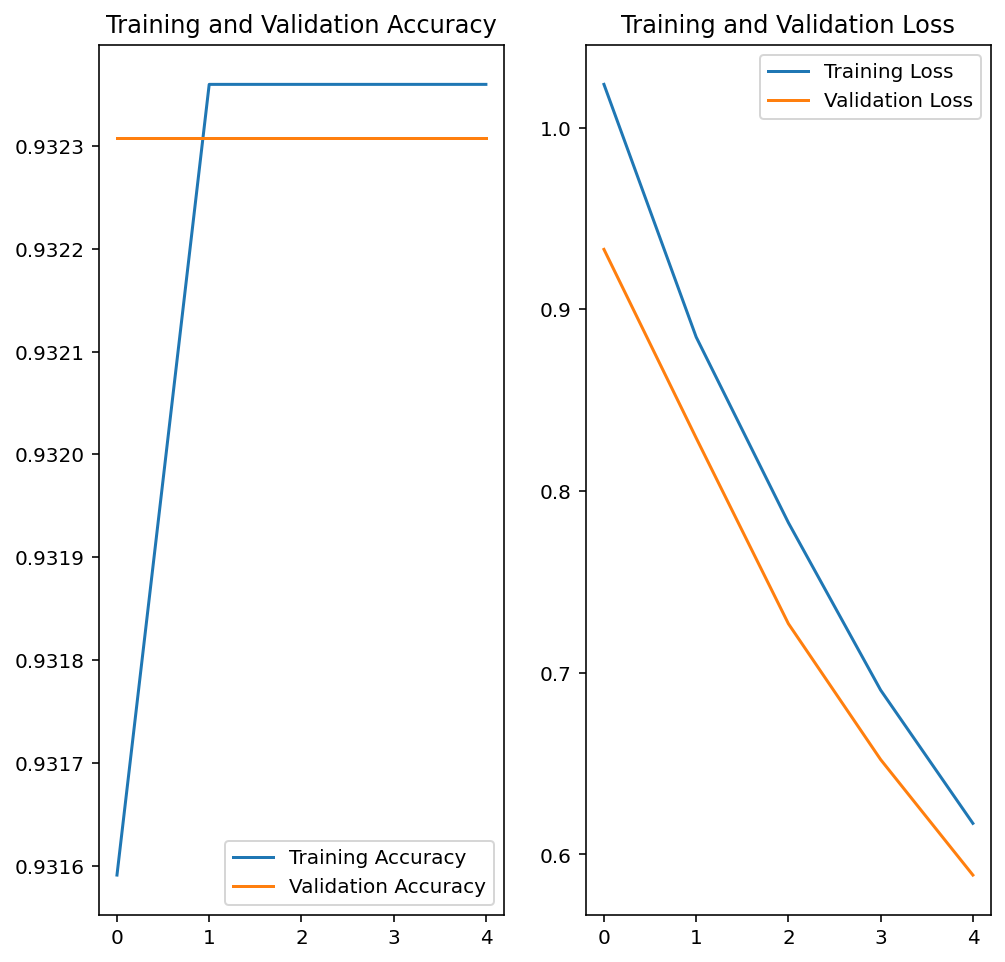

In [ ]:
# Plot the loss and accuracy values achieved during training for the training and validation set.
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
oss, accuracy = model_3.evaluate(test_generator)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))

25/25 [==============================] - 22s 849ms/step - loss: 0.6077 - accuracy: 0.9350

Loss on the TEST Set: 0.248
Accuracy on the TEST Set: 93.501%


##Work on MFCC coffecients 

In [ ]:
import json

with open("test_features.json", "r") as read_file:
   data = json.load(read_file)

labels=[]
ids=[]
MFCC_coff=[]
pairs = data.items()
for key, value in pairs:
    pairs2= value.items()
    for key2,value2 in pairs2:
      if (type(value2) == str and value2[-1]!='g'): #get label values only
        labels.append(value2)
      elif (type(value2)==str) : #get id of audio
        ids.append(value2)
      else :
        MFCC_coff.append(value2)  #do seperation here

MFCC_1=[]
MFCC_2=[]
MFCC_3=[]
MFCC_4=[]
MFCC_5=[]
MFCC_6=[]
MFCC_7=[]
MFCC_8=[]
MFCC_9=[]
MFCC_10=[]
MFCC_11=[]
MFCC_12=[]
MFCC_13=[]
for i in range(len(MFCC_coff)):
  #print(MFCC_coff[i][0])
  MFCC_1.append(MFCC_coff[i][0] ) #which will be used in csv
for i in range(len(MFCC_coff)):
  #print(MFCC_coff[i][0])
  MFCC_2.append(MFCC_coff[i][1] ) #which will be used in csv

for i in range(len(MFCC_coff)):
  #print(MFCC_coff[i][0])
  MFCC_3.append(MFCC_coff[i][2] ) #which will be used in csv

for i in range(len(MFCC_coff)):
  #print(MFCC_coff[i][0])
  MFCC_4.append(MFCC_coff[i][3] ) #which will be used in csv
for i in range(len(MFCC_coff)):
  #print(MFCC_coff[i][0])
  MFCC_5.append(MFCC_coff[i][4] ) #which will be used in csv


for i in range(len(MFCC_coff)):
  #print(MFCC_coff[i][0])
  MFCC_6.append(MFCC_coff[i][5] ) #which will be used in csv


for i in range(len(MFCC_coff)):
  #print(MFCC_coff[i][0])
  MFCC_7.append(MFCC_coff[i][6] ) #which will be used in csv


for i in range(len(MFCC_coff)):
  #print(MFCC_coff[i][0])
  MFCC_8.append(MFCC_coff[i][7] ) #which will be used in csv


for i in range(len(MFCC_coff)):
  #print(MFCC_coff[i][0])
  MFCC_9.append(MFCC_coff[i][8] ) #which will be used in csv

for i in range(len(MFCC_coff)):
  #print(MFCC_coff[i][0])
  MFCC_10.append(MFCC_coff[i][9] ) #which will be used in csv


for i in range(len(MFCC_coff)):
  #print(MFCC_coff[i][0])
  MFCC_11.append(MFCC_coff[i][10] ) #which will be used in csv


for i in range(len(MFCC_coff)):
  #print(MFCC_coff[i][0])
  MFCC_12.append(MFCC_coff[i][11] ) #which will be used in csv


for i in range(len(MFCC_coff)):
  #print(MFCC_coff[i][0])
  MFCC_13.append(MFCC_coff[i][12] ) #which will be used in csv



print(MFCC_1)      
print(MFCC_2)
print(MFCC_3)
print(MFCC_13)


[-167.4629977511144, -154.615660755316, -187.6614769551593, -274.81884005855034, -136.78685507552393, -153.5328300746172, -77.70550715975617, -157.0659176245871, -111.30372810031344, -138.19666557674313, -148.11997623549243, -191.34955967057778, -150.3846708236717, -143.4335438708282, -240.64587699035644, -128.69272390450956, -87.39858637462163, -157.50516070207522, -162.84808963712763, -129.72348933308976, -203.2904022996569, -134.76878169740746, -141.21040614840317, -170.13651640521041, -171.95429633629928, -175.85221293491986, -210.8925747179482, -192.18190013359253, -131.70673437906638, -165.86002653211216, -200.28628927422838, -162.2999735582946, -144.46292739429572, -337.01358983538074, -131.93140483442437, -155.73219949526498, -204.9766734522034, -188.65719942783454, -209.93486660796106, -145.33737996127869, -260.38959781617996, -96.52692361416055, -90.01512539475036, -136.03217157405908, -143.87128536865757, -149.7835354191496, -127.46480778694867, -128.45359408256596, -175.166

In [ ]:
import csv

fieldnames=[ 'ID', 'Labels','MFCC_1','MFCC_2','MFCC_3','MFCC_4','MFCC_5','MFCC_6','MFCC_7','MFCC_8','MFCC_9','MFCC_10','MFCC_11','MFCC_12','MFCC_13']
#fieldnames=[ 'ID', 'Labels','MFCC_1']


# open the file in the write mode
with open('test_features.csv', 'w') as f:
    # create the csv writer
    #writer = csv.writer(f)
    print("file is created")

    writer = csv.DictWriter(f, fieldnames=fieldnames)

    writer.writeheader()
    for i in range (len(labels)):
        writer.writerow({'Labels': labels[i], 
                         'ID': ids[i], 
                         'MFCC_1':MFCC_1[i],'MFCC_2':MFCC_2[i],'MFCC_3':MFCC_3[i],'MFCC_4':MFCC_4[i],'MFCC_5':MFCC_5[i],'MFCC_6':MFCC_6[i]
                          ,'MFCC_7':MFCC_7[i],'MFCC_8':MFCC_8[i],'MFCC_9':MFCC_9[i],'MFCC_10':MFCC_10[i],'MFCC_11':MFCC_11[i],'MFCC_12':MFCC_12[i],'MFCC_13':MFCC_13[i]
                         }) #labels & id is done :)
    #writer.writerow("labels") # write on raws
    #writer.writerows(labels) #write on colums

    print("Done")

file is created
Done


# 4 -Model Architecture

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [ ]:
trained_data= pd.read_csv('train_features_final.csv')
#label_encoder object knows how to understand word labels
label_encoder = preprocessing.LabelEncoder()
  
#Encode labels in column Sex and Embarked
trained_data['Labels']= label_encoder.fit_transform(trained_data['Labels'])
trained_data['ID']= label_encoder.fit_transform(trained_data['ID'])


In [ ]:
trained_data.head()
trained_data['ID'].value_counts()


2047    1
4783    1
657     1
4755    1
2708    1
       ..
1362    1
3411    1
5460    1
1366    1
0       1
Name: ID, Length: 6212, dtype: int64

In [ ]:
#Setting the value for dependent and independent variables
X_train = trained_data.drop('Labels', 1)
y_train = trained_data.Labels

In [ ]:
tested_data= pd.read_csv('test_features.csv')
#label_encoder object knows how to understand word labels
label_encoder = preprocessing.LabelEncoder()
  
#Encode labels in column Sex and Embarked
tested_data['Labels']= label_encoder.fit_transform(tested_data['Labels'])
tested_data['ID']= label_encoder.fit_transform(tested_data['ID'])

In [ ]:
tested_data.head()
tested_data['Labels'].value_counts()
#Setting the value for dependent and independent variables
X_test = tested_data.drop('Labels', 1)
y_test = tested_data.Labels

In [ ]:
#Fitting the Logistic Regression model

lr_model = LogisticRegression() #instance of the LogisticRegression class
lr_model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#Prediction of test set
y_pred = lr_model.predict(X_test)
#Predicted values
y_pred


array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
#Actual value and the predicted value
a = pd.DataFrame({'Actual value': y_test, 'Predicted value':y_pred})
a.head()


,Actual value,Predicted value
0,0,0
1,1,0
2,0,0
3,0,0
4,0,0


In [ ]:
a['Actual value'].value_counts()


0    1432
1     122
Name: Actual value, dtype: int64

In [ ]:
a['Predicted value'].value_counts()


0    1554
Name: Predicted value, dtype: int64

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1432
           1       0.00      0.00      0.00       122

    accuracy                           0.92      1554
   macro avg       0.46      0.50      0.48      1554
weighted avg       0.85      0.92      0.88      1554



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


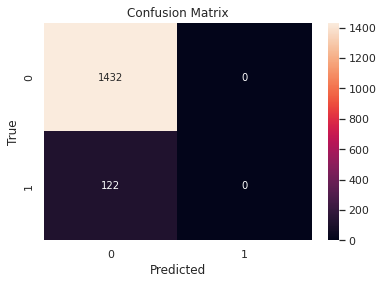

In [ ]:
#Confusion matrix and classification report
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
print(classification_report(y_test, y_pred))


In [ ]:
from distutils.dir_util import copy_tree


In [ ]:
shutil.move("/content/virufy-cdf-coughvid/train_melspecs", "/content/drive/MyDrive/Audio/train")

'/content/drive/MyDrive/Audio/train'

In [ ]:
shutil.move("/content/virufy-cdf-coughvid/test_melspecs", "/content/drive/MyDrive/Audio")

'/content/drive/MyDrive/Audio/test_melspecs'

'/content/drive/MyDrive/train_melspecs'

In [ ]:
c=0
for x in os.walk("/content/drive/MyDrive/Audio/"):
  print((x))

('/content/drive/MyDrive/Audio/', ['train_melspecs', 'train', 'test_melspecs'], [])
('/content/drive/MyDrive/Audio/train_melspecs', [], ['b6202957-96a2-421b-af3c-1e26ec95f1c2.png', 'a7b6f651-0138-41a1-a837-015dcb75699c.png', '991ef17b-14ac-4457-8048-87276dd1a752.png', 'b1ddcad3-7f53-417a-862c-84066d72e140.png', 'f849e1f9-ad92-44c1-b4cb-3fe8c66e1214.png', 'ecd2441a-fe87-475c-8e83-0b9f7bf69767.png', 'f68cae45-25e9-4eb4-a83f-ab22a09c4b86.png', 'fdcdae2d-4552-48c7-a940-59a6ae297b27.png', 'babe4887-ac1e-4033-84bd-786783e55b3e.png', 'ef4b3fa8-7c0d-4220-b3b3-47b581d1085b.png', '4613beb0-6e70-4cab-8eb8-470cd2d36bea.png', '439cfb08-40d5-4dbd-ab87-27900768ddce.png', '5cc60202-8998-426d-8e01-e05fc091f7ed.png', '135182e3-1747-4e1a-99eb-2520a5e0f607.png', 'bbce40e6-3523-4159-b844-fce6c1790126.png', '391ed7c1-9386-4c5e-b4b0-2b5a118cbb6e.png', '825f9e27-c37b-4b94-adc5-8183716d1229.png', 'b1821263-6041-423f-93d6-a174d97bc4d7.png', '881d892d-f3a9-4409-82d3-1f43c7ce5047.png', '32cfca54-20cd-47d8-91c8-24

In [ ]:
import os
c=0
l=0
for x in os.walk("/content/drive/MyDrive/train_melspecs"):
  c=c+1
  if c==2:
    l=x[2]
  print((x))

7766

In [ ]:
for i in l:
  try:
    shutil.move("/content/drive/MyDrive/Audio/train_melspecs/"+i, "/content/drive/MyDrive/Audio/train")
  except:
    "do no thing"

In [ ]:
shutil.move("/content/drive/MyDrive/Audio/train_melspecs/", "/content/drive/MyDrive/Audio/train")